# Bayesian inference for Poisson Processes

Simplest case : perform Bayesian inference for simulated HPP.

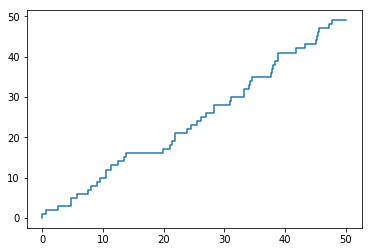

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
%matplotlib inline

# Plot realization of unit rate Poisson process.
Lambda, T, t_curr = 1, 50, 0
N_t = np.array([0])
arrivals = [0]
while t_curr <  T:
    random_arrival = expon.rvs(scale=1/Lambda, size=1)[0]
    arrivals.append(random_arrival+arrivals[-1])
    N_t = np.append(N_t, N_t[-1]+1)
    t_curr += random_arrival
plt.step(arrivals, N_t)

Assume $\text{Gamma}(\alpha, \beta)$ prior, then posterior is $\text{Gamma}(\alpha+n, \beta+T)$, $T=50$.

Text(0.5,1,'Gamma(100, 50) prior')

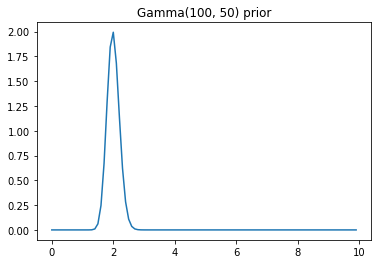

In [3]:
from scipy.stats import gamma

prior_alpha, prior_beta= 100, 50
xvals = np.arange(0,10,0.1)
yvals = gamma.pdf(xvals, a=prior_alpha, scale=1/prior_beta)
plt.plot(xvals, yvals)
plt.title('Gamma({}, {}) prior'.format(prior_alpha, prior_beta))

Text(0.5,1,'Gamma(149, 100) posterior')

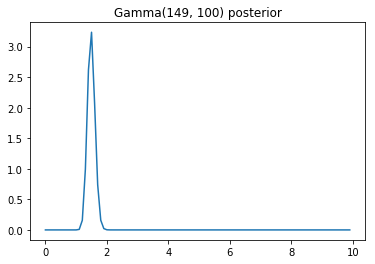

In [4]:
post_alpha, post_beta= prior_alpha + N_t[-1], prior_beta + T 
xvals = np.arange(0,10,0.1)
yvals = gamma.pdf(xvals, a=post_alpha, scale=1/post_beta)
plt.plot(xvals, yvals)
plt.title('Gamma({}, {}) posterior'.format(post_alpha, post_beta))

Generate an inhomogeneous Poisson process of rate $\lambda(t)=a e^{-bt}$, and estimate parameters $a$ and $b$ in a Bayesian framework. NHPP is simulated by the thinning algorithm in Lewis & Schedler, 1979.

Text(0.5,1,'NHPP : $\\lambda(t) = ae^{-bt}$')

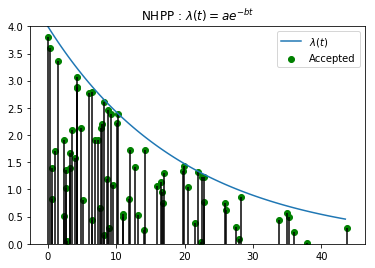

In [5]:
from scipy.stats import uniform

def NHPP_lambda(a, b, t): # intensity function for NHPP as in example 2.3 in Insua et al, 2012.
    return a*np.exp(-b*t)

a, b = 4, 0.05
# T=50 as before
M = a
t = 0
T=50
arrivals, N_t, unifs = [], [], []
while t < T:
    #E = expon.rvs(scale=1/M,size=1)[0]
    E = np.random.exponential(scale=1/M)
    t += E
    U = uniform.rvs(loc=0, scale=M)
    if t < T and U <= NHPP_lambda(a,b,t):
        arrivals.append(t)
        unifs.append(U)
        if len(N_t)==0:
            N_t.append(1)
        else:
            N_t.append(N_t[-1]+1)
tvals = np.arange(0, arrivals[-1], 0.5)
plt.plot(tvals, NHPP_lambda(a, b, tvals), label='$\lambda(t)$')
plt.scatter(arrivals, unifs, label='Accepted', c='green')
for i in range(len(unifs)):
    plt.vlines(x = arrivals[i], ymin=0, ymax=unifs[i])
plt.legend(loc='best')
plt.ylim(0, M)
plt.title('NHPP : $\lambda(t) = ae^{-bt}$')

First do one parameter case : $\lambda(t) = e^{-bt}$.

0.06083173939773848


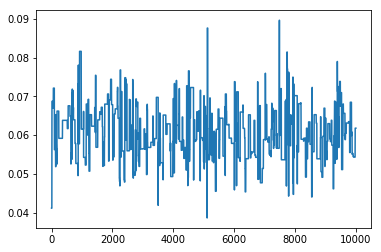

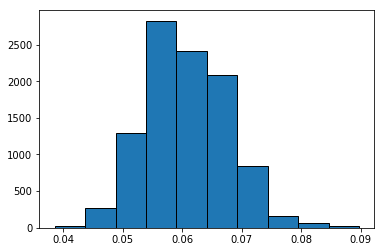

In [6]:
from scipy.stats import truncnorm,norm

N = 10000
curr = 0.2
samples = []

# Assume parameter a is known (see above)
alpha, beta = 4, 9.5
def posterior_b(a, b, alpha, beta, arrivals, T):
    exp_term = -beta*b+(a/b)*(np.exp(-b*T)-1)-b*np.sum(arrivals)
    return (b**(alpha-1))*np.exp(exp_term)

# Sample b using random walk Metropolis
# Use normal distribution
for i in range(N):
    x = norm.rvs(loc=curr,scale=0.2)
    posterior_curr = posterior_b(a, curr, alpha, beta, arrivals, T)
    posterior_at_x = posterior_b(a, x, alpha, beta, arrivals, T)
    ratio = min(1, posterior_at_x/posterior_curr)
    U = uniform.rvs(size=1)[0]
    if U <= ratio:
        curr = x 
    samples.append(curr)
plt.plot(range(N), samples)
plt.figure()
plt.hist(samples, ec='black')
print(np.mean(samples))

Works ! The expression for posterior of $b$ is:

$$p(b | \{t_{n}\}) \propto b^{\alpha-1} \cdot \exp \Big[ -\beta b + \frac{3}{b}(e^{-bT}-1) - b\sum_{i=1}^{n}t_{i}\Big]$$

Text(0.5,1,'Samples of a, mean : 4.467767738747294')

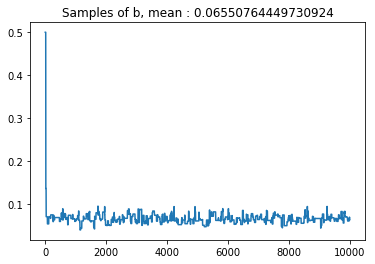

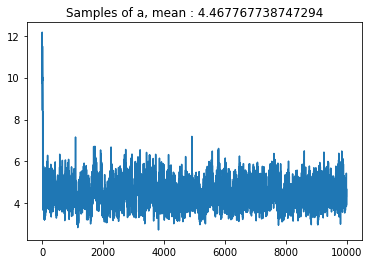

In [7]:
# Now sample both parameters a and b using systematic scan Gibbs sampler.

samples_of_b , samples_of_a = [], []
alpha1, beta1 = 32, 8
alpha2, beta2 = 4, 9.5
curr_a, curr_b = 1, 0.5

for i in range(N):
    new_a = gamma.rvs(a = alpha1+len(arrivals), scale = 1/(beta1+ (1/curr_b)*(1-np.exp(-curr_b*T))))
    x = norm.rvs(loc=curr,scale=0.2)
    posterior_curr = posterior_b(new_a, curr, alpha2, beta2, arrivals, T)
    posterior_at_x = posterior_b(new_a, x, alpha2, beta2, arrivals, T)
    ratio = min(1, posterior_at_x/posterior_curr)
    U = uniform.rvs(size=1)[0]
    if U <= ratio:
        curr_b = x
    curr_a = new_a
    samples_of_a.append(curr_a)
    samples_of_b.append(curr_b)
plt.plot(range(N), samples_of_b)
plt.title('Samples of b, mean : {}'.format(np.mean(samples_of_b)))
plt.figure()
plt.plot(range(N), samples_of_a)
plt.title('Samples of a, mean : {}'.format(np.mean(samples_of_a)))

In [8]:
np.var(samples_of_b), np.var(samples_of_a)

(0.0003705373683496699, 0.37763359369233035)

## Simulate a Hawkes process

Intensity function will be of form:

$$\lambda^{*}(t) = \lambda + a\sum_{t_{i}<t} b \cdot e^{-b(t-t_{i})}$$

Thus the likelihood is given by:

$$ L(\lambda, a, b | \{t_{n}\}) \propto \exp\Big(-\int_{0}^{T}\lambda^{*}(t)dt\Big)
\prod_{i=1}^{N} \lambda^{*}(t_{i})$$

$$ = \exp\Big(-\int_{0}^{T}\big(\lambda + a\sum_{t_{i}<t}b\cdot e^{-b(t-t_{i})}\big)dt\Big)
\prod_{j=1}^{N} \big(\lambda + a\sum_{i=1}^{i-1}b\cdot e^{-b(t_{j}-t_{i})}\big)$$

where $N$ is the number of arrivals (i.e. spikes). Simulate a Hawkes process using thinning, with parameters $\lambda = 1, a=0.5, b=5.$

Text(0,0.5,'$\\lambda(t)$')

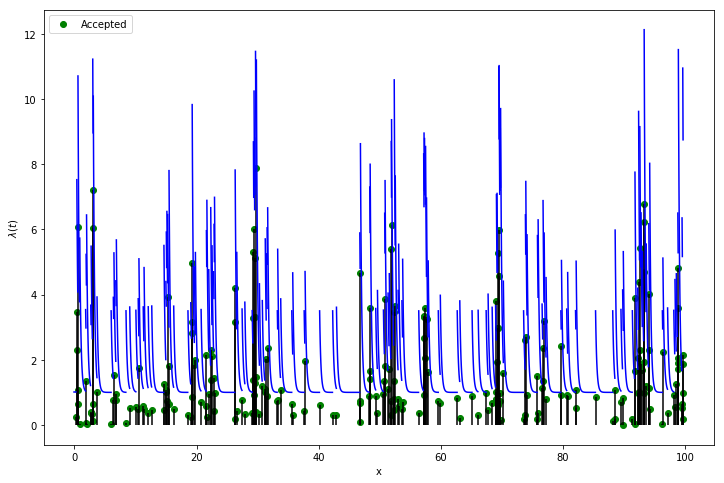

In [16]:
lmbd, a, b = 1, 0.5, 5

def Hawkes_CIF(lmbd, a, b, arrivals, t):
    f = lambda t,arriv : a*b*np.exp(-b*(t-arriv))
    return lmbd + np.sum(f(np.ones(len(arrivals),)*t, arrivals))

t, T, arrivals, unifs = 0, 100, [], []
eps = 10**(-10)
while t < T:
    M = Hawkes_CIF(lmbd, a, b, arrivals, t+eps)
    E = np.random.exponential(scale=1/M)
    t += E
    U = uniform.rvs(loc=0, scale=M)
    if t<T and U <= Hawkes_CIF(lmbd, a, b, arrivals, t):
        arrivals.append(t)
        unifs.append(U)
plt.figure(figsize=(12,8))
#tvals = np.arange(0, arrivals[-1], 0.5)
plt.scatter(arrivals, unifs, label='Accepted', c='green')
for i in range(len(unifs)):
    plt.vlines(x = arrivals[i], ymin=0, ymax=unifs[i])
tvals_for_base = np.arange(0, arrivals[0], 0.05)
plt.plot(tvals_for_base, np.ones(len(tvals_for_base),)*lmbd, color='blue')
for k in range(len(arrivals)-1):
    tvals_per_arrival = np.arange(arrivals[k], arrivals[k+1], 0.05)
    lambda_vals = [Hawkes_CIF(lmbd, a, b, arrivals[:k+1], tvals_per_arrival[j]) for j in range(len(tvals_per_arrival))]
    plt.plot(tvals_per_arrival, lambda_vals, color='blue')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('$\lambda(t)$')

In [83]:
# Perform Bayesian inference on parameter lmbd, a, b using Metropolis within Gibbs sampler.
# I used Exp(0.01) priors; non-informative priors can't be used, see Rasmussen,2011.
import warnings
from scipy.stats import truncnorm
#warnings.filterwarnings("error")

#scale_lmbd, scale_a, scale_b = 1, 1, 2  # standard deviation for proposal distributions
def log_prod_CIF(lmbd, a, b, arrivals):
        return np.sum([np.log(Hawkes_CIF(lmbd, a, b, arrivals[:j], arrivals[j])) for j in range(len(arrivals))])

def log_exp_term(a, b, T, arrivals):
    return -a*len(arrivals) + a*np.sum([np.exp(-b*(T-arr)) for arr in arrivals])


def Hawkes_MH_within_Gibbs(T, arrivals, scale_lmbd, scale_a, scale_b, N):
    
    alpha, beta = 3/2, 1       # prior for lmbd and a
    alpha_b, beta_b = 4, 1/2   # prior for b
    # Use truncated normal as proposal distribution for MH.
    lower, upper = 0, 100 # use these for all three parameters.
    
    # Sample the initial values
    curr_lmbd, curr_a, curr_b = gamma.rvs(a=alpha, scale=1/beta), gamma.rvs(a=alpha, scale=1/beta), gamma.rvs(a=alpha_b,scale=1/beta_b)
    
    samples_of_lmbd, samples_of_a, samples_of_b = [], [], []
    accepted_lmbd, accepted_a, accepted_b = 0.0, 0.0, 0.0
    
    # For truncated normal
    def prop_bounds(lower, upper, mean, sd):
        return (lower-mean)/sd, (upper-mean)/sd

    for i in range(N):
        try:
            lower_curr, upper_curr = prop_bounds(lower, upper, curr_lmbd, scale_lmbd)
            cand_lmbd = truncnorm.rvs(a=lower_curr, b=upper_curr, loc=curr_lmbd, scale=scale_lmbd)
            #cand_lmbd = np.random.exponential(scale=1)
            lower_cand, upper_cand = prop_bounds(lower, upper, cand_lmbd, scale_lmbd)
            lmbd_pdf_at_curr = -curr_lmbd*T+log_prod_CIF(curr_lmbd, curr_a, curr_b, arrivals)+np.log(
                np.exp(-beta*curr_lmbd)*curr_lmbd**(alpha-1))
            lmbd_pdf_at_cand = -cand_lmbd*T+log_prod_CIF(cand_lmbd, curr_a, curr_b, arrivals)+np.log(
                np.exp(-beta*cand_lmbd)*cand_lmbd**(alpha-1))
            prop_at_curr = truncnorm.pdf(curr_lmbd, a=lower_cand, b=upper_cand, loc=cand_lmbd, scale=scale_lmbd)
            prop_at_cand = truncnorm.pdf(cand_lmbd, a=lower_curr, b=upper_curr, loc=curr_lmbd, scale=scale_lmbd)
            ratio1 = min(0, lmbd_pdf_at_cand + np.log(prop_at_curr) - lmbd_pdf_at_curr - np.log(prop_at_cand))
            U = uniform.rvs()
            if U <= np.exp(ratio1):
                curr_lmbd = cand_lmbd
                accepted_lmbd += 1
            samples_of_lmbd.append(curr_lmbd)

            # Next update a
            lower_curr, upper_curr = prop_bounds(lower, upper, curr_a, scale_a)
            cand_a = truncnorm.rvs(a=lower_curr, b=upper_curr, loc=curr_a, scale=scale_a)
            lower_cand, upper_cand = prop_bounds(lower, upper, cand_a, scale_a)
            a_pdf_at_curr = log_exp_term(curr_a, curr_b, T, arrivals)+log_prod_CIF(
                curr_lmbd, curr_a, curr_b, arrivals)+np.log(np.exp(-beta*curr_a)*curr_a**(alpha-1))
            a_pdf_at_cand = log_exp_term(cand_a, curr_b, T, arrivals)+log_prod_CIF(
                curr_lmbd, cand_a, curr_b, arrivals)+np.log(np.exp(-beta*cand_a)*cand_a**(alpha-1))
            prop_at_curr = truncnorm.pdf(curr_a, a=lower_cand, b=upper_cand, loc=cand_a, scale=scale_a)
            prop_at_cand = truncnorm.pdf(cand_a, a=lower_curr, b=upper_curr, loc=curr_a, scale=scale_a)
            ratio2 = min(0, a_pdf_at_cand + np.log(prop_at_curr) - a_pdf_at_curr - np.log(prop_at_cand))
            U = uniform.rvs()
            if U <= np.exp(ratio2):
                curr_a = cand_a
                accepted_a += 1
            samples_of_a.append(curr_a)

            # Update b
            lower_curr, upper_curr = prop_bounds(lower, upper, curr_b, scale_b)
            cand_b = truncnorm.rvs(a=lower_curr, b=upper_curr, loc=curr_b, scale=scale_b)
            lower_cand, upper_cand = prop_bounds(lower, upper, cand_b, scale_b)
            b_pdf_at_curr = log_exp_term(curr_a, curr_b, T, arrivals)+log_prod_CIF(
                curr_lmbd, curr_a, curr_b, arrivals)+np.log(np.exp(-beta_b*curr_b)*curr_b**(alpha_b-1))
            b_pdf_at_cand = log_exp_term(curr_a, cand_b, T, arrivals)+log_prod_CIF(
                curr_lmbd, curr_a, cand_b, arrivals)+np.log(np.exp(-beta_b*cand_b)*cand_b**(alpha_b-1))
            prop_at_curr = truncnorm.pdf(curr_b, a=lower_cand, b=upper_cand, loc=cand_b, scale=scale_b)
            prop_at_cand = truncnorm.pdf(cand_b, a=lower_curr, b=upper_curr, loc=curr_b, scale=scale_b)
            ratio3 = min(0, b_pdf_at_cand + np.log(prop_at_curr) - b_pdf_at_curr - np.log(prop_at_cand))
            U = uniform.rvs()
            if U <= np.exp(ratio3):
                curr_b = cand_b
                accepted_b += 1
            samples_of_b.append(curr_b)

            #print(np.exp(ratio1), np.exp(ratio2), np.exp(ratio3))
        except RuntimeWarning:
            #import ipdb; ipdb.set_trace()
            print(curr_a)
            print(np.sum(np.log([Hawkes_CIF(cand_lmbd, curr_a, curr_b, arrivals[:j], arrivals[j]) for j in range(len(arrivals))])), '\n')

    plt.figure()    
    plt.plot(range(N), samples_of_b)
    plt.title('Samples of b, mean : {}, acceptance: {}'.format(round(np.mean(samples_of_b[int(N/3):]),3), accepted_b/N))
    plt.figure()
    plt.plot(range(N), samples_of_a)
    plt.title('Samples of a, mean : {}, acceptance: {}'.format(round(np.mean(samples_of_a[int(N/3):]),3), accepted_a/N))
    plt.figure()
    plt.plot(range(N), samples_of_lmbd)
    plt.title('Samples of $\lambda$, mean : {}, accepted: {}'.format(round(np.mean(samples_of_lmbd[int(N/3):]),3), accepted_lmbd/N))
    return samples_of_lmbd, samples_of_a, samples_of_b

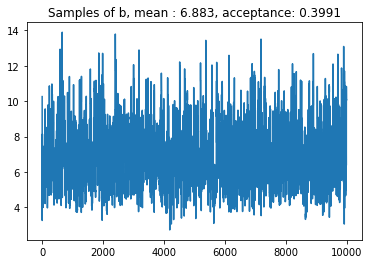

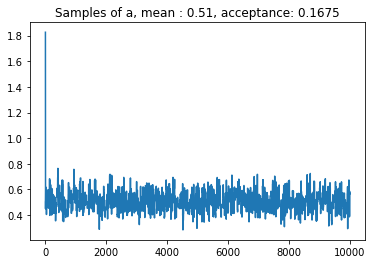

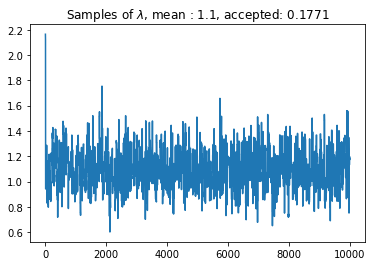

In [65]:
samples_lmbd, samples_a, samples_b = Hawkes_MH_within_Gibbs(T, arrivals, 1, 0.5, 4, 10000)

In [66]:
burnin = int(N/3)  # consider samples after burn-in
samples_lmbd, samples_a, samples_b = samples_lmbd[burnin:], samples_a[burnin:], samples_b[burnin:]

In [67]:
print(lmbd, a, b)

1 0.5 5


For every (different) simulation, the algorithm converges, in some cases the estimates are good, others are worse. For each simulated realization I tried, the algorithm's convergence is invariant to starting values. 

In [68]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_autocorrelation(*args):
    for i in range(len(args)):
        fig, ax = plt.subplots(figsize=(14,5))
        plot_acf(args[i][0], ax);
        plt.title('Autocorrelation of {}'.format(args[i][1]))

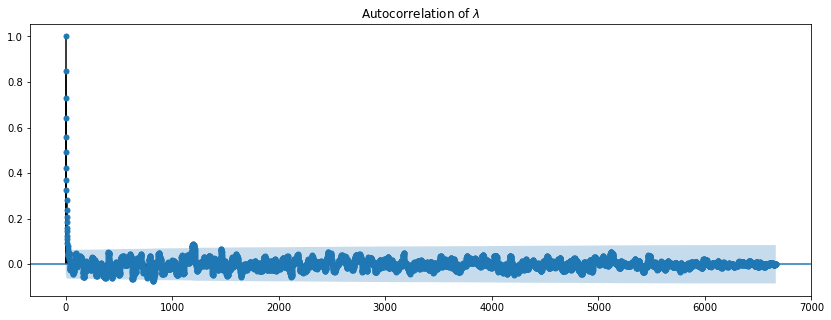

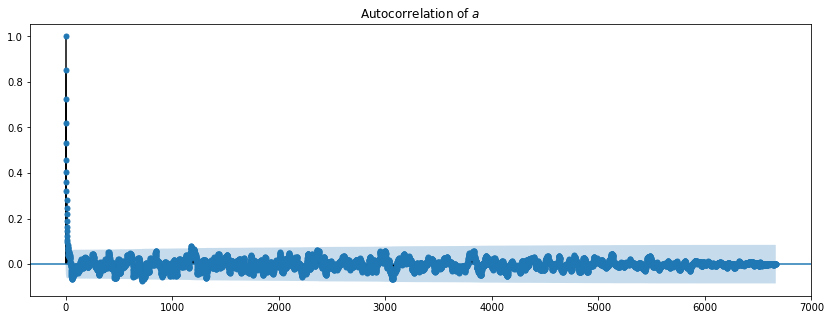

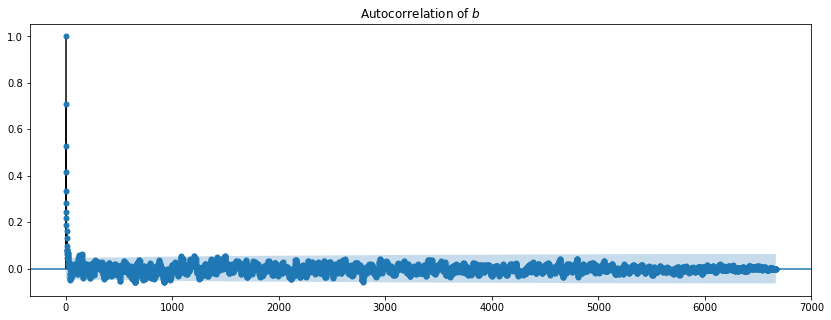

In [69]:
plot_autocorrelation((samples_lmbd, '$\lambda$'), (samples_a, '$a$'), (samples_b, '$b$'))

### TO DO : so far I have three spiking datasets:
Disjk & Fenton - which I don't understand where they come from

Timme et al - documented, probably not the type of neurons I want

Frank et al - documented, need to open the .gz archive file

### Mitchell et al - [DATA](https://snl.salk.edu/~jude/neuron_exchange/index.html)

In [84]:
file = open(r"C:\Users\ad15865\OneDrive - University of Bristol\Documents\Downloads\Mitchell et al - Data\mzir50u1_t1.csv", 'r')
lines = file.readlines()
# Include suffix '1' to denote data for trial 1.
times1 = np.array([float(entry) for entry in lines[0].split(',') if float(entry)>=0])/10
times1[:10]

array([ 7.8475,  8.0125,  8.1825,  9.515 ,  9.835 , 10.06  , 12.64  ,
       13.345 , 13.497 , 15.682 ])

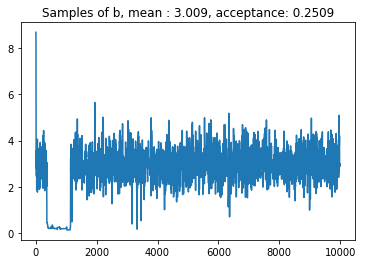

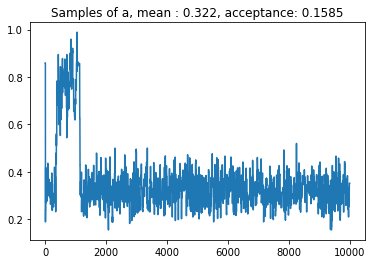

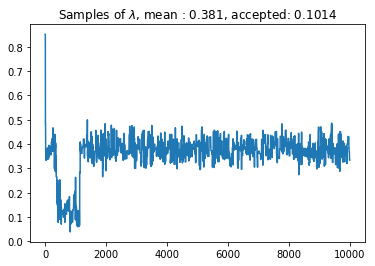

In [87]:
lmbd1, a1, b1 = Hawkes_MH_within_Gibbs(max(times1), times1, 0.5, 0.5, 3, 10000)

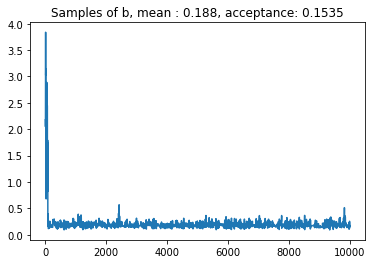

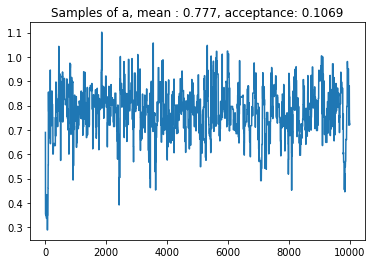

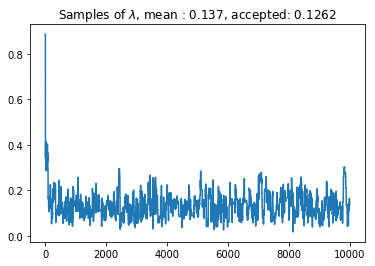

In [81]:
# Same data but using a prior for b with mass concentrated on low values, Gamma(1,1/2)
lmbd1, a1, b1 = Hawkes_MH_within_Gibbs(max(times1), times1, 0.5, 1, 0.5, 10000)

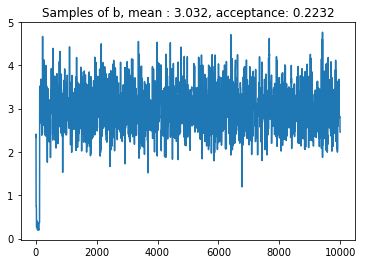

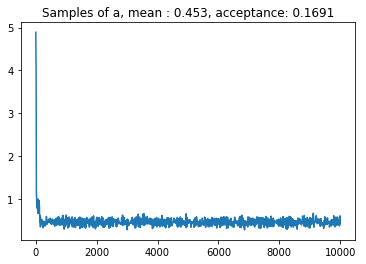

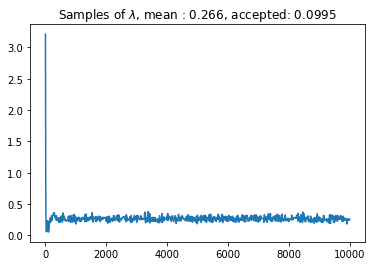

In [85]:
# Same neuron, different trial
file = open(r"C:\Users\ad15865\OneDrive - University of Bristol\Documents\Downloads\Mitchell et al - Data\mzir50u1_t6.csv", 'r')
lines = file.readlines()
# Include suffix '6' to denote data for trial 6.
times6 = np.array([float(entry) for entry in lines[0].split(',') if float(entry)>=0])/10
lmbd6, a6, b6 = Hawkes_MH_within_Gibbs(max(times6), times6, 0.5, 0.5, 3, 10000)

$\textbf{Model Fit}$ - under progress

In [ ]:
# Function to compute the compensator for Hawkes process with excitation function h(t) = a*b*exp(-b*t)
def Hawkes_compensator(arrivals, t, lmbd, a, b):
    return lmbd*t + alpha*np.sum([(1-np.exp(-b*(t-arr))) for arr in arrivals])

def Hawkes_time_rescales(comps):
    """
    Return rescaled values of the compensators, as described in Brown et al.,2002
    If model describes data, then these values should be i.i.d. U[0,1]
    """
    return [1-np.exp(comps[i-1]- comps[i]) for i in range(1,len(comps))]

# Sampled parameter values for trial 6.
lmbd6, a6, b6= np.mean(lmbd6[int(len(lmbd6)/3):]), np.mean(a6[int(len(a6)/3):]), np.mean(b6[int(len(b6)/3):])
#comps = [Hawkes_compensator(arrivals[:j], arrivals[j], lmbd6, a6, b6) for j in range(len(arrivals))]
#rescales = Hawkes_time_rescales(comps)

In [ ]:
lmbd6, a6, b6

In [ ]:
# Now write perform posterior predictive checks (see Gelman, 2013), compared to a baseline of HPP of MLE rate.
# This is evaluated on test data using parameters fitted on training data
# Training and test datasets will be two distinct trials.

# def predictive_log_likelihood(lmbd, a, b, test_data, train_data):
#     T = max(test_data)
#     N = length(test_data)
#     MLE_rate = N/T   # MLE rate for homogeneous Poisson process.
#     log_likelihood_HPP = -

T_data = max(times/10)
log_likelihood_HPP = -len(times) + len(times)*np.log(len(times)/T_data)
log_my_likelihood = -lmbd6*T_data + log_exp_term(a6, b6, T_data, times/10) +  log_prod_CIF(lmbd6, a6, b6, times/10)
(log_likelihood_HPP - log_my_likelihood)/len(times), log_likelihood_HPP, log_my_likelihood

## Different model?

Suppose the CIF at time $t$ is only affected by the previous spike.